# Analysing the effectiveness of non-pharmaceutical interventions

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import linear_model 

import datetime

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

### Some parameters have to be defined manually

In [2]:
# Define the time range which starts interval_start days before the death_limit and
# ends interval_end days after the death_limit
# The death limit will identify the date when at least death_limit_per_million people per million 
# has died in the country

interval_start = 30
interval_end = 60
death_limit_per_million = 1

short_interval_end = 30  # This is defined to identify the traffic at the beginning of the epidemic

minimum_days_npi = 3   # NPI must last at least minimum_days_npi days this interval to be considered

# 'Czechia', and 'North Macedonia', 'Luxembourg', 'Slovakia', 'Latvia', dropped for now because 
# it would require more data cleaning than what is done so far

num_nordic_countries = 4  # How many countries at the beginning of the list are Nordic

european_countries = ['Sweden', 'Denmark', 'Finland', 'Norway', 
    'Germany', 'France', 'United Kingdom','Italy',
    'Spain', 'Ukraine', 
    'Poland', 'Romania',
    'Netherlands', 'Belgium', 'Greece', 'Portugal',
    'Hungary', 'Belarus', 
    'Austria', 'Switzerland',
    'Bulgaria', 'Serbia', 'Ireland', 
    'Croatia', 'Bosnia and Herzegovina',
    'Lithuania', 'Moldova', 'Slovenia',
    'Estonia']

# Values so that a restriction (school_closing, workplace_closing,...) is considered required
closing_mins_req = [2,2,2,3, 2,2,2,2]

# If you change dataframe df_index's columns, change this list as well!
measured_factors = ["school_closing", "workplace_closing", "cancel_public_events", 
    "restrictions_on_gatherings","close_public_transport", "stay_at_home_requirements", 
    "restrictions_on_internal_movement", "international_travel_controls"]

In [3]:
# These directly follow from manual definitions 
num_countries = len(european_countries)
len_interval = interval_start + interval_end  
len_measured_factors = len(measured_factors)

### There are three dataframes used in this notebook. The first one 'df_countries' holds general countrywise information, the second one 'dtypes_days' holds countrywise data which changes daily and the third one 'dtypes_npi_interval' holds information of countrywise NPI-intervals.

In [4]:
######################################
# Create a dataframe sorted by countries

dtypes_countries = np.dtype([
          ('country', str),
          ('population_density', float),
          ('aged_65_older', float),
          ('aged_70_older', float),
          ('gdp_per_capita', float),
          ('diabetes_prevalence', float),
          ('female_smokers', float),
          ('male_smokers', float),
          ('hospital_beds_per_thousand', float),
          ('obesity', float),
          ('pisa_results', float),
          ('trust_in_others', float),
          ('total_tests_per_thousand_last', float),
          ('means_traffic_beginning', float),
          ('means_traffic_end', float),
          ('total_deaths_per_million_last', float),
          ])
data_countries = np.empty(0, dtype=dtypes_countries)
df_countries = pd.DataFrame(data_countries)   


######################################
# Create a dataframe sorted by days

dtypes_days = np.dtype([
          ('country', str),
          ('date', np.datetime64),
          ('new_infections', int),
          ('new_deaths', int),
          ('total_deaths_per_million', float),
          ('total_traffic', float),
          ('npi_developments', float),
          ('school_closing', float),
          ('workplace_closing', float),    
          ('cancel_public_events', float),    
          ('restrictions_on_gatherings', float),    
          ('close_public_transport', float),
          ('stay_at_home_requirements', float),
          ('restrictions_on_internal_movement', float),    
          ('international_travel_controls', float),    
          ('public_information_campaigns', float),        
          ])
data_days = np.empty(0, dtype=dtypes_days)
df_days = pd.DataFrame(data_days)


######################################
# Create a dataframe sorted by NPI-intervals

dtypes_npi_interval = np.dtype([
          ('country', str),
          ('interval_start_date', np.datetime64),
          ('npi_interval_len', int),
          ('npi_increment', float),
          ('infected_coefficients', float),
          ('infected_intercepts', float),
          ('traffic_coefficients', float),
          ('traffic_intercepts', float),
          ])
data_npi_interval = np.empty(0, dtype=dtypes_npi_interval)
df_npi_interval = pd.DataFrame(data_npi_interval)   


######################################
# Create a dataframe with normalized days. Useful to compare if countries had NPIs at similar times

dtypes_index = np.dtype([
          ('school_closing_req_on', object),
          ('workplace_closing_req_on', object),
          ('cancel_public_events_req_on', object),
          ('restrictions_on_gatherings_req_on', object),
          ('close_public_transport_req_on', object),
          ('stay_at_home_req_on', object),
          ('restrictions_on_internal_movement_req_on', object),
          ('international_travel_controls_req_on', object),
          ('school_closing_req_off', object),
          ('workplace_closing_req_off', object),
          ('cancel_public_events_req_off', object),
          ('restrictions_on_gatherings_req_off', object),
          ('close_public_transport_req_off', object),
          ('stay_at_home_req_off', object),
          ('restrictions_on_internal_movement_req_off', object),    
          ('international_travel_controls_req_off', object),
          ])
data_index = np.empty(0, dtype=dtypes_index)
df_index = pd.DataFrame(data_index)


######################################
# Create a dataframe where a column is an implemented NPI which allows comparement between different NPIs

dtypes_index = np.dtype([
          ('NPI', str),
          ('num_countries_implemented', int),
          ('num_countries_not_implemented', int),
          ('implementation_percentage', float),
          ('countries_implemented', object),
          ('countries_not_implemented', object),
          ])
data_index = np.empty(0, dtype=dtypes_index)
df_npis_on = pd.DataFrame(data_index)


######################################
# Create a dataframe where a column is a NPI which was pulled off

dtypes_index = np.dtype([
          ('NPI', str),
          ('countries_implemented', int),
          ('possible_countries_not_implemented', int),  
          ('implementation_percentage_possible', float), 
          ])
data_index = np.empty(0, dtype=dtypes_index)
df_npis_off = pd.DataFrame(data_index)

### Let's download 'Our World in Data COVID-19'- dataset and add its data to dataframes 'df_countries' and 'df_days'

In [5]:
def load_covid_data():
    url = 'owid-covid-data.csv'
    data = pd.read_csv(url)
    return data

df_covid_data = load_covid_data()


df_obesity_data = pd.read_csv('share-of-adults-defined-as-obese.csv')

df_pisa_data = pd.read_csv('pisa-test-score-mean-performance-on-the-science-scale.csv')

df_trust_data = pd.read_csv('average-rating-of-trust-in-others-selected-countries.csv')

In [6]:
# Find the day of the death limit
date_death_limit = []

for current_country in european_countries:
    current_date_as_string = df_covid_data.loc[
        (df_covid_data['total_deaths_per_million'] >= death_limit_per_million) &
        (df_covid_data['location'] == current_country), 'date'].values[0]
    
    date_death_limit.append(datetime.datetime.strptime(current_date_as_string, '%Y-%m-%d'))
 
    
date_end_point = []

for current_date in date_death_limit:
    date_end_point.append(current_date + datetime.timedelta(days=interval_end))

In [7]:
for i in range(num_countries):
    
    current_country = european_countries[i]
    
    current_population_density = df_covid_data.loc[(df_covid_data['location'] == current_country),
                        'population_density'].values[0]
    
    current_aged_65_older = df_covid_data.loc[(df_covid_data['location'] == current_country),
                            'aged_65_older'].values[0]
    
    current_aged_70_older = df_covid_data.loc[(df_covid_data['location'] == current_country),
                            'aged_70_older'].values[0]
    
    current_gdp_per_capita = df_covid_data.loc[(df_covid_data['location'] == current_country),
                            'gdp_per_capita'].values[0]
    
    current_diabetes_prevalence = df_covid_data.loc[(df_covid_data['location'] == current_country),
                            'diabetes_prevalence'].values[0]
    
    current_female_smokers = df_covid_data.loc[(df_covid_data['location'] == current_country),
                            'female_smokers'].values[0]
    
    current_male_smokers = df_covid_data.loc[(df_covid_data['location'] == current_country),
                            'male_smokers'].values[0]
    
    current_hospital_beds_per_thousand = df_covid_data.loc[(df_covid_data['location'] == current_country),
                            'hospital_beds_per_thousand'].values[0]
        
    current_obesity = df_obesity_data.loc[(df_obesity_data['Entity'] == current_country),
                            'Obesity'].values[-1]
    
    # Some of the PISA-values are missing and have to be manually added
    current_pisa = np.NaN
    if df_pisa_data.loc[(df_pisa_data['Entity'] == current_country),'PISA: science'].values.size > 0:
        current_pisa = df_pisa_data.loc[(df_pisa_data['Entity'] == current_country),
                            'PISA: science'].values[-1]
    
    # The same thing with trust. Data for missing values exist but the quality is not great
    current_trust = np.NaN
    if df_trust_data.loc[(df_trust_data['Entity'] == current_country),'Trust'].values.size > 0:    
        current_trust = df_trust_data.loc[(df_trust_data['Entity'] == current_country),
                            'Trust'].values[-1]
    
    # And total tests
    current_total_tests_list = df_covid_data.loc[(df_covid_data['location'] == current_country) &
            (df_covid_data['date'] <= date_end_point[i].strftime('%Y-%m-%d')),
            'new_tests_smoothed_per_thousand'].values
    current_total_tests_list = [x for x in current_total_tests_list if np.isnan(x) == False]
    current_total_tests_per_thousand = np.NaN
    if current_total_tests_list:
        current_total_tests_per_thousand = current_total_tests_list[-1]

    
    new_data = {'country': [current_country], 
                'population_density': [current_population_density],
                'aged_65_older': [current_aged_65_older], 
                'aged_70_older': [current_aged_70_older], 
                'gdp_per_capita': [current_gdp_per_capita], 
                'diabetes_prevalence': [current_diabetes_prevalence], 
                'female_smokers': [current_female_smokers], 
                'male_smokers': [current_male_smokers], 
                'hospital_beds_per_thousand': [current_hospital_beds_per_thousand],
                'obesity': [current_obesity], 
                'pisa_results': [current_pisa],
                'trust_in_others': [current_trust],
                'total_tests_per_thousand_last': [current_total_tests_per_thousand],
                'means_traffic_beginning': [0.0],
                'means_traffic_end': [0.0], 
                'total_deaths_per_million_last': [0.0] } 
    
    df_extention = pd.DataFrame(new_data, index = [i])
    df_countries = pd.concat([df_countries, df_extention])
    
# Add a missing Serbia current_aged_70_older value

df_countries['aged_70_older'][european_countries.index('Serbia')] = 14.4

/home/tommi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [8]:
columns = ['country','date', 'new_infected', 'new_deaths', 'total_deaths_per_million']

for i in range(num_countries):
    current_country = european_countries[i]
    start_date = date_death_limit[i] - datetime.timedelta(days=interval_start) 
    end_date = date_death_limit[i] + datetime.timedelta(days=interval_end) 
    
    current_country_list = [current_country] * len_interval
    date_list = [start_date + datetime.timedelta(days=x) for x in range(len_interval)]
    
    new_infections = df_covid_data.loc[(df_covid_data['date'] >= start_date.strftime('%Y-%m-%d'))&
                  (df_covid_data['date'] < end_date.strftime('%Y-%m-%d'))&
                  (df_covid_data['location'] == current_country), 'new_cases'].tolist()
    
    new_deaths = df_covid_data.loc[(df_covid_data['date'] >= start_date.strftime('%Y-%m-%d'))&
                  (df_covid_data['date'] < end_date.strftime('%Y-%m-%d'))&
                  (df_covid_data['location'] == current_country), 'new_deaths'].tolist()

    total_deaths_per_million = df_covid_data.loc[
                  (df_covid_data['date'] >= start_date.strftime('%Y-%m-%d'))&
                  (df_covid_data['date'] < end_date.strftime('%Y-%m-%d'))&
                  (df_covid_data['location'] == current_country), 'total_deaths_per_million'].tolist()
    
    # Make sure counting starts early enough
    if len(new_infections) < len_interval:
        n = len_interval - len(new_infections)
        new_infections = [new_infections[0]] * n + new_infections
        new_deaths = [new_deaths[0]] * n + new_deaths
        total_deaths_per_million = [total_deaths_per_million[0]] * n + total_deaths_per_million
    
    # There are very few NaN and one negative value in columns that need to be cleaned separately!
    for j in range(len_interval -1):
        if np.isnan(new_infections[j]) or new_infections[j] < 0:
            new_infections[j] = 0 #new_infections[j+1]
        if np.isnan(new_deaths[j]) or new_deaths[j] < 0:
            new_deaths[j] = 0 # new_deaths[j+1]
        if np.isnan(total_deaths_per_million[j]) or total_deaths_per_million[j] < 0:
            total_deaths_per_million[j] = 0 #total_deaths_per_million[j+1]
    
    new_data = {'country':current_country_list, 'date': date_list, 'new_infections': new_infections,
                'new_deaths': new_deaths, 'total_deaths_per_million': total_deaths_per_million } 
    
    df_extention = pd.DataFrame(new_data)
    df_days = pd.concat([df_days, df_extention])

    # Update also the deaths to countrywise dataframe
    df_countries['total_deaths_per_million_last'][i] = total_deaths_per_million[-1]

/home/tommi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Let's download and clean Google's traffic data and add it to dataframe 'df_days'

In [9]:
def load_mobility_raw_onlynan():
    # url = 'https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv'
    url = 'Global_Mobility_Report.csv'
    data = pd.read_csv(url)
    data = data[data['sub_region_1'].isna()]
    data["date"] = pd.to_datetime(data["date"])
    
    data['retail_and_recreation_percent_change_from_baseline']=data.groupby('country_region_code')['retail_and_recreation_percent_change_from_baseline'].fillna(method='ffill')
    data['retail_and_recreation_percent_change_from_baseline']=data.groupby('country_region_code')['retail_and_recreation_percent_change_from_baseline'].fillna(method='bfill')
    data['grocery_and_pharmacy_percent_change_from_baseline']=data.groupby('country_region_code')['grocery_and_pharmacy_percent_change_from_baseline'].fillna(method='ffill')
    data['grocery_and_pharmacy_percent_change_from_baseline']=data.groupby('country_region_code')['grocery_and_pharmacy_percent_change_from_baseline'].fillna(method='bfill')
    data['parks_percent_change_from_baseline']=data.groupby('country_region_code')['parks_percent_change_from_baseline'].fillna(method='ffill')
    data['parks_percent_change_from_baseline']=data.groupby('country_region_code')['parks_percent_change_from_baseline'].fillna(method='bfill')
    data['transit_stations_percent_change_from_baseline']=data.groupby('country_region_code')['transit_stations_percent_change_from_baseline'].fillna(method='ffill')
    data['transit_stations_percent_change_from_baseline']=data.groupby('country_region_code')['transit_stations_percent_change_from_baseline'].fillna(method='bfill')
    data['workplaces_percent_change_from_baseline']=data.groupby('country_region_code')['workplaces_percent_change_from_baseline'].fillna(method='ffill')
    data['workplaces_percent_change_from_baseline']=data.groupby('country_region_code')['workplaces_percent_change_from_baseline'].fillna(method='bfill')
    data['residential_percent_change_from_baseline']=data.groupby('country_region_code')['residential_percent_change_from_baseline'].fillna(method='ffill')
    data['residential_percent_change_from_baseline']=data.groupby('country_region_code')['residential_percent_change_from_baseline'].fillna(method='bfill')

    data['workplaces_percent_change_from_baseline']=data.groupby('country_region_code')['workplaces_percent_change_from_baseline'].apply(lambda group: group.interpolate(method='index'))
    
    datav=data.values
    tot_mobility=list()
    for j in range(datav.shape[0]):
        temp=np.nanmean([datav[j,h] for h in range(7,13,1)])
        tot_mobility.append(temp)
        
    data=data.dropna(subset=['country_region'])

    data['Total Mobility']=tot_mobility
    data['Total Mobility']=data.groupby('country_region_code')['Total Mobility'].fillna(method='ffill')
    data['Total Mobility']=data.groupby('country_region_code')['Total Mobility'].fillna(method='bfill')
    data['Smooth Mobility']=data.groupby('country_region_code')['Total Mobility'].rolling(window = 7, win_type='boxcar').mean().reset_index(0,drop=True)
    data['Smooth Mobility']=data.groupby('country_region_code')['Smooth Mobility'].fillna(method='ffill')
    data['Smooth Mobility']=data.groupby('country_region_code')['Smooth Mobility'].fillna(method='bfill')
    data['Smooth Mobility']=data.groupby('country_region_code')['Smooth Mobility'].apply(lambda group: group.interpolate(method='index'))
    data=data.drop(columns=['sub_region_2','sub_region_1', 'iso_3166_2_code', 'census_fips_code'])
    
    return data

In [10]:
df0 = load_mobility_raw_onlynan()

total_traffic = []

for i in range(num_countries):
    current_country = european_countries[i]
    start_date = date_death_limit[i] - datetime.timedelta(days=interval_start)  
    end_date = start_date + datetime.timedelta(days=len_interval)
    
    new_total_traffic = df0.loc[(df0['date'] >= start_date.strftime('%Y-%m-%d'))&
                  (df0['date'] < end_date.strftime('%Y-%m-%d'))&
                  (df0['country_region'] == current_country), 'Total Mobility'].tolist()

    if len(new_total_traffic) < len_interval:
        new_total_traffic = [0] * (len_interval-len(new_total_traffic)) + new_total_traffic
    
    total_traffic = total_traffic + new_total_traffic
    
    means_traffic_beginning = sum(new_total_traffic[0:short_interval_end]) / short_interval_end
    means_traffic_end = sum(new_total_traffic[0:len_interval]) / len_interval
    
    df_countries.loc[df_countries.index == i, 'means_traffic_beginning'] = means_traffic_beginning
    df_countries.loc[df_countries.index == i, 'means_traffic_end'] = means_traffic_end
    
df_days['total_traffic'] = total_traffic

/home/tommi/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/home/tommi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice


### Let's download data from 'The Oxford COVID-19 Government Response Tracker (OxCGRT)' and add its data in the dataframe 'df_days' and 'df_npi_interval'. Let's update also dataframe 'df_npi'.

In [11]:
# This can be removed with small modifications
def load_npis():
    url = 'covid-stringency-index.csv'
    data = pd.read_csv(url)
    
    data["Date"] = pd.to_datetime(data["Date"])
    return data

def int_to_string(string_raw):
    return str(string_raw)

def load_npis_raw():
    url = 'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv'
    data = pd.read_csv(url)
    
    data['Date'] = data['Date'].apply(int_to_string)
    data["Date"] = pd.to_datetime(data["Date"], format='%Y-%m-%d')
    return data

In [12]:
df_npis_temp = load_npis()

npi_developments = []  # Multiple values possible for the same NPI inteval

infected_sorted_by_npi = [] # Infected grouped by NPI intervals
traffic_sorted_by_npi = []  # Traffic grouped by NPI intervals

changepoint_intervals = []  # Tells on which interval the changepoint belongs to

df0 = load_mobility_raw_onlynan() # Download the traffic data


for i in range(len(european_countries)):
    
    # Define the country inside the loop, also its time interval
    current_country = european_countries[i]
    interval_start_point = date_death_limit[i] - datetime.timedelta(days=interval_start)
    interval_end_point = date_death_limit[i] + datetime.timedelta(days=interval_end)
    
    # Define the npi-development and also same for the traffic
    current_npi_development = df_npis_temp.loc[(df_npis_temp['Entity'] == current_country) &
        (df_npis_temp['Date'] >= interval_start_point) & (df_npis_temp['Date'] < interval_end_point), 'GRSI'].tolist()
    
    current_traffic = df_days[(df_days['country'] == current_country)]['total_traffic'].tolist()
    
    current_new_infections = df_days[(df_days['country'] == current_country)]['new_infections'].tolist()
    
    # The development of NPIs can be added directly
    npi_developments = npi_developments + current_npi_development
    
    # Variables to help to update the dataframe df_npi_interval
    interval_start_date = interval_start_point      # This can be implemented better
    npi_increment = current_npi_development[0]    # This can be implemented better
    npi_interval_len_counter = 0
    npi_interval_index_counter = 0
    
    # Interval-lists will be added to current_infected_sorted and current_traffic_sorted!
    current_infected_sorted = []
    current_traffic_sorted = []
    current_infected_interval = []
    current_traffic_interval = []
    
    
    for j in range(len(current_npi_development) -1):
        npi_interval_len_counter += 1
        
        current_infected_interval.append(current_new_infections[j])
        current_traffic_interval.append(current_traffic[j])   
    
        # If NPIs are changed...
        if (current_npi_development[j] != current_npi_development[j+1]):
            
            # Concate a new row of the current country to the dataframe
            new_data = {'country': [current_country], 'interval_start_date': [interval_start_date],
                'npi_interval_len': [npi_interval_len_counter], 'npi_increment': [npi_increment]} 
            df_extention = pd.DataFrame(new_data, index = [npi_interval_index_counter])
            df_npi_interval = pd.concat([df_npi_interval, df_extention])

            # Update the variables
            interval_start_date = interval_start_point + datetime.timedelta(days=j+1)
            npi_increment = current_npi_development[j+1] - current_npi_development[j]
            npi_interval_len_counter = 0
            npi_interval_index_counter += 1    
            
            # As well the infected and the traffic sorted
            current_infected_sorted.append(current_infected_interval)
            current_infected_interval = []
            current_traffic_sorted.append(current_traffic_interval)
            current_traffic_interval = []
                
            # If the last two elements are different
            if j == len(current_npi_development) -2:
                
                # Update the current_infected_sorted and current_traffic_sorted
                current_infected_sorted.append([current_new_infections[j+1]])
                current_traffic_sorted.append([current_traffic[j+1]])
                
                # Concate a new row of the current country to the dataframe
                new_data = {'country': [current_country], 'interval_start_date': [interval_start_date],
                'npi_interval_len': [1], 'npi_increment': [npi_increment]} 
                df_extention = pd.DataFrame(new_data, index = [npi_interval_index_counter])
                df_npi_interval = pd.concat([df_npi_interval, df_extention])
        
        
        # If the last two elements are the same
        elif j == len(current_npi_development) -2:
            
            # Update the current_infected_sorted and current_traffic_sorted
            current_infected_interval.append(current_new_infections[j+1])
            current_traffic_interval.append(current_traffic[j+1])  
            current_infected_sorted.append(current_infected_interval)
            current_traffic_sorted.append(current_traffic_interval)
            
            # Concate a new row of the current country to the dataframe
            new_data = {'country': [current_country], 'interval_start_date': [interval_start_date],
            'npi_interval_len': [npi_interval_len_counter+1], 'npi_increment': [npi_increment]} 
            df_extention = pd.DataFrame(new_data, index = [npi_interval_index_counter])
            df_npi_interval = pd.concat([df_npi_interval, df_extention])

    infected_sorted_by_npi.append(current_infected_sorted)
    traffic_sorted_by_npi.append(current_traffic_sorted)

df_days['npi_developments'] = npi_developments

/home/tommi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice


In [13]:
infected_coefficients = []
infected_intercepts = []

traffic_coefficients = []
traffic_intercepts = []

for i in range(len(european_countries)):
    for j in range(len(infected_sorted_by_npi[i])):
        y_infected =  np.array(infected_sorted_by_npi[i][j])
        y_traffic =  np.array(traffic_sorted_by_npi[i][j])
        x = np.arange(len(y_infected)).reshape((-1, 1))
        
        if len(x) >= 2:
            regr = linear_model.LinearRegression()
                        
            regr.fit(x, y_infected)
            infected_coefficients = infected_coefficients + [regr.coef_[0]]
            infected_intercepts = infected_intercepts + [regr.intercept_]
            
            regr.fit(x, y_traffic)
            traffic_coefficients = traffic_coefficients + [regr.coef_[0]]
            traffic_intercepts = traffic_intercepts + [regr.intercept_]
            
        # For one point, it is impossible to fit a line
        else:
            infected_coefficients = infected_coefficients + [-1000]
            infected_intercepts = infected_intercepts + [-1000]
            
            traffic_coefficients = traffic_coefficients + [-1000]
            traffic_intercepts = traffic_intercepts + [-1000]
            
df_npi_interval['infected_coefficients'] = infected_coefficients
df_npi_interval['infected_intercepts'] = infected_intercepts

df_npi_interval['traffic_coefficients'] = traffic_coefficients
df_npi_interval['traffic_intercepts'] = traffic_intercepts

In [14]:
df_npis_raw = load_npis_raw()

school_closings = []
workplace_closings = []
cancel_public_events = []
restrictions_on_gatherings = []
close_public_transports = []
stay_at_home_requirements = []
restrictions_on_internal_movements = []
international_travel_controls = []
public_information_campaigns = []

for i in range(len(european_countries)):
    
    # Define the country inside the loop, also its time interval
    current_country = european_countries[i]
    interval_start_point = date_death_limit[i] - datetime.timedelta(days=interval_start)
    interval_end_point = date_death_limit[i] + datetime.timedelta(days=interval_end)
    # Current dataframe, based on the country
    df_current = df_npis_raw[(df_npis_raw['Date'] >= interval_start_point) & 
      (df_npis_raw['Date'] < interval_end_point)& (df_npis_raw['CountryName'] == current_country)]
    
    current_school_closing = df_current['C1_School closing'].tolist()
    school_closings = school_closings + current_school_closing
    
    current_workplace_closing = df_current['C2_Workplace closing'].tolist()
    workplace_closings = workplace_closings + current_workplace_closing
    
    current_cancel_public_events = df_current['C3_Cancel public events'].tolist()
    cancel_public_events = cancel_public_events + current_cancel_public_events
    
    current_restrictions_on_gatherings = df_current['C4_Restrictions on gatherings'].tolist()
    restrictions_on_gatherings = restrictions_on_gatherings + current_restrictions_on_gatherings
    
    current_close_public_transport = df_current['C5_Close public transport'].tolist()
    close_public_transports = close_public_transports + current_close_public_transport
    
    current_stay_at_home_requirements = df_current['C6_Stay at home requirements'].tolist()
    stay_at_home_requirements = stay_at_home_requirements + current_stay_at_home_requirements
    
    current_restrictions_on_internal_movement = df_current['C7_Restrictions on internal movement'].tolist()
    restrictions_on_internal_movements = restrictions_on_internal_movements + current_restrictions_on_internal_movement
    
    current_international_travel_controls = df_current['C8_International travel controls'].tolist()
    international_travel_controls = international_travel_controls + current_international_travel_controls
    
    current_public_information_campaigns = df_current['H1_Public information campaigns'].tolist()
    public_information_campaigns = public_information_campaigns + current_public_information_campaigns
    
df_days['school_closing'] = school_closings
df_days['workplace_closing'] = workplace_closings
df_days['cancel_public_events'] = cancel_public_events
df_days['restrictions_on_gatherings'] = restrictions_on_gatherings
df_days['close_public_transport'] = close_public_transports
df_days['stay_at_home_requirements'] = stay_at_home_requirements
df_days['restrictions_on_internal_movement'] = restrictions_on_internal_movements
df_days['international_travel_controls'] = international_travel_controls
df_days['public_information_campaigns'] = public_information_campaigns

In [15]:
# school_closing_req_ons, school_closing_req_offs, workplace_closing_req_ons, workplace_closing_req_offs, ...
closing_reqs = [ [] for _ in range(len_measured_factors * len_interval) ] 
opening_reqs = [ [] for _ in range(len_measured_factors * len_interval) ] 
# k + j*len_interval

for i in range(len(european_countries)): # loop over countries
    # Define the country inside the loop, also its time interval
    current_country = european_countries[i]
    # Current dataframe, based on the country
    df_days_current = df_days[(df_days['country'] == current_country)]
    
    for j in range(len_measured_factors): # loop over all the restrictions
        prev_value= 0
        current_factor = measured_factors[j]
        
        # Make sure countries won't f.e. close school twice. Without these two variables, it would be possible 
        # f.e. if countries would close first all all but universities and later also them
        can_add_closure = True
        can_add_opening = True
        
        for k in range(len_interval):   # loop over the interval
            
            if ( can_add_closure and (prev_value < df_days_current.at[k, current_factor]) and 
            (closing_mins_req[j] <= df_days_current.at[k, current_factor]) ):
                closing_reqs[k + j*len_interval].append(current_country)
                can_add_closure = False
                
            if ( can_add_opening and (prev_value > df_days_current.at[k, current_factor]) and 
            (closing_mins_req[j] > df_days_current.at[k, current_factor]) ):
                opening_reqs[k + j*len_interval].append(current_country)     
                can_add_opening = False
    
            prev_value = df_days_current.at[k, current_factor]
        
        
for k in range(len_interval):   # loop over the interval
    new_data = {'school_closing_req_on': [closing_reqs[k + 0*len_interval]], 
                'workplace_closing_req_on': [closing_reqs[k + 1*len_interval]], 
                'cancel_public_events_req_on': [closing_reqs[k + 2*len_interval]], 
                'restrictions_on_gatherings_req_on': [closing_reqs[k + 3*len_interval]], 
                'close_public_transport_req_on': [closing_reqs[k + 4*len_interval]],
                'stay_at_home_req_on': [closing_reqs[k + 5*len_interval]],
                'restrictions_on_internal_movement_req_on': [closing_reqs[k + 6*len_interval]],
                'international_travel_controls_req_on': [closing_reqs[k + 7*len_interval]], 
                'school_closing_req_off': [opening_reqs[k + 0*len_interval]],
                'workplace_closing_req_off': [opening_reqs[k + 1*len_interval]], 
                'cancel_public_events_req_off': [opening_reqs[k + 2*len_interval]], 
                'restrictions_on_gatherings_req_off': [opening_reqs[k + 3*len_interval]], 
                'close_public_transport_req_off': [opening_reqs[k + 4*len_interval]], 
                'stay_at_home_req_off': [opening_reqs[k + 5*len_interval]],
                'restrictions_on_internal_movement_req_off': [opening_reqs[k + 6*len_interval]],
                'international_travel_controls_req_off': [opening_reqs[k + 7*len_interval]] 
               } 

    df_extention = pd.DataFrame(new_data, index = [k])
    df_index = pd.concat([df_index, df_extention])

In [16]:
i = 0
for current_npi in list(df_index.columns.values):
    current_column = df_index[current_npi].tolist()
    countries_implemented = []
    
    if i < len_measured_factors:
        for j in current_column:
            countries_implemented = countries_implemented + j
        
        num_countries_implemented = len(countries_implemented)
        num_countries_not_implemented = num_countries - num_countries_implemented
        implementation_percentage = num_countries_implemented / num_countries
        
        countries_not_implemented = list(set(european_countries) - set(countries_implemented))
        
        new_data = {'NPI': [current_npi], 
                    'num_countries_implemented': [num_countries_implemented],
                    'num_countries_not_implemented': [num_countries_not_implemented],
                    'implementation_percentage': [implementation_percentage], 
                    'countries_implemented': [countries_implemented],
                    'countries_not_implemented': [countries_not_implemented]
                   } 

        df_extention = pd.DataFrame(new_data, index = [i])
        df_npis_on = pd.concat([df_npis_on, df_extention])
    
    i += 1

### Implemented dataframes

In [17]:
# Dataframe sorted by countries 
df_countries 

,country,population_density,aged_65_older,aged_70_older,gdp_per_capita,diabetes_prevalence,female_smokers,male_smokers,hospital_beds_per_thousand,obesity,pisa_results,trust_in_others,total_tests_per_thousand_last,means_traffic_beginning,means_traffic_end,total_deaths_per_million_last
0,Sweden,24.718,19.985,13.433,46949.283,4.79,18.8,18.9,2.220,20.6,493.422400,6.9,0.440,-1.238889,-2.333333,366.165
1,Denmark,136.520,19.677,12.325,46682.515,6.41,19.3,18.8,2.500,19.7,501.936900,8.3,2.106,-2.044444,-2.892593,94.437
2,Finland,18.136,21.228,13.264,40585.721,5.76,18.3,22.6,3.280,22.2,530.661200,7.4,0.452,-5.466667,-8.448148,55.588
3,Norway,14.462,16.821,10.813,64800.057,5.31,19.6,20.7,3.600,23.1,498.481100,7.3,0.388,-4.288889,-7.592593,42.795
4,Germany,237.016,21.453,15.957,45229.245,8.31,28.2,33.1,8.000,22.3,509.140600,5.5,0.638,-2.644444,-11.079630,97.238
5,France,122.578,19.718,13.079,38605.671,4.77,30.1,35.6,5.980,21.6,494.977600,5.0,NaN,0.716667,-31.312963,408.175
6,United Kingdom,272.898,18.517,12.527,39753.244,4.28,20.0,24.7,2.540,27.8,509.221500,6.1,0.919,0.677778,-23.333333,500.810
7,Italy,205.859,23.021,16.240,35220.084,4.78,19.8,27.8,3.180,19.9,480.546800,5.7,0.936,-0.416667,-32.425926,467.005
8,Spain,93.105,19.436,13.799,34272.360,7.17,27.4,31.4,2.970,23.8,492.786100,6.3,0.873,3.116667,-33.998148,569.375
9,Ukraine,77.390,16.462,11.133,7894.393,7.11,13.5,47.4,8.800,24.1,NaN,NaN,0.235,-17.850000,-16.118519,17.767


In [18]:
# Dataframe sorted by days
#pd.set_option('display.max_rows', None)
df_days

,country,date,new_infections,new_deaths,total_deaths_per_million,total_traffic,npi_developments,school_closing,workplace_closing,cancel_public_events,restrictions_on_gatherings,close_public_transport,stay_at_home_requirements,restrictions_on_internal_movement,international_travel_controls,public_information_campaigns
0,Sweden,2020-02-20,0.0,0.0,0.000,-1.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Sweden,2020-02-21,0.0,0.0,0.000,3.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Sweden,2020-02-22,0.0,0.0,0.000,-2.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Sweden,2020-02-23,0.0,0.0,0.000,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Sweden,2020-02-24,0.0,0.0,0.000,3.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,Estonia,2020-05-24,14.0,0.0,48.246,4.333333,50.0,1.0,2.0,2.0,4.0,0.0,0.0,0.0,2.0,2.0
86,Estonia,2020-05-25,2.0,0.0,48.246,7.166667,50.0,1.0,2.0,2.0,4.0,0.0,0.0,0.0,2.0,2.0
87,Estonia,2020-05-26,1.0,1.0,49.000,12.333333,50.0,1.0,2.0,2.0,4.0,0.0,0.0,0.0,2.0,2.0
88,Estonia,2020-05-27,10.0,0.0,49.000,11.166667,50.0,1.0,2.0,2.0,4.0,0.0,0.0,0.0,2.0,2.0


In [19]:
# Dataframe sorted by NPI intervals
df_npi_interval

,country,interval_start_date,npi_interval_len,npi_increment,infected_coefficients,infected_intercepts,traffic_coefficients,traffic_intercepts
0,Sweden,2020-02-20,18,0.00,2.167183,-9.532164,0.067939,1.061404
1,Sweden,2020-03-09,3,11.11,18.000000,37.000000,0.166667,-0.111111
2,Sweden,2020-03-12,6,5.56,-11.171429,160.428571,-1.395238,-2.428571
3,Sweden,2020-03-18,1,3.70,-1000.000000,-1000.000000,-1000.000000,-1000.000000
4,Sweden,2020-03-19,6,8.33,-2.371429,147.428571,-0.880952,-5.325397
...,...,...,...,...,...,...,...,...
8,Estonia,2020-04-27,11,-2.78,-0.654545,10.363636,1.793939,-21.000000
9,Estonia,2020-05-08,3,-8.33,0.500000,6.166667,10.666667,-8.222222
10,Estonia,2020-05-11,4,-3.71,0.000000,4.500000,3.100000,-15.650000
11,Estonia,2020-05-15,3,-7.40,-1.500000,7.833333,0.166667,-10.055556


In [20]:
# Create a dataframe with normalized days. Useful to compare if countries had NPIs at similar times
df_index

,school_closing_req_on,workplace_closing_req_on,cancel_public_events_req_on,restrictions_on_gatherings_req_on,close_public_transport_req_on,stay_at_home_req_on,restrictions_on_internal_movement_req_on,international_travel_controls_req_on,school_closing_req_off,workplace_closing_req_off,cancel_public_events_req_off,restrictions_on_gatherings_req_off,close_public_transport_req_off,stay_at_home_req_off,restrictions_on_internal_movement_req_off,international_travel_controls_req_off
0,[],[],[],[],[],[],[],"[Finland, France, Italy, Romania]",[],[],[],[],[],[],[],[]
1,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
2,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
3,[Ukraine],[],[Ukraine],[],[],[],[Ukraine],[],[],[],[],[],[],[],[],[]
4,[Germany],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,[],[],[],[],[],[],[],[],[],[],[],[],[Norway],[Ireland],[],[]
86,[],[],[],[],[],[],[],[],[Austria],[],[],[],[],"[United Kingdom, Netherlands]",[],[]
87,[],[],[],[],[],[],[],[],[],[],[],[],[],[],"[Germany, Croatia]",[]
88,[],[],[],[],[],[],[],[],[],[],"[Poland, Croatia]","[Poland, Croatia]",[],"[France, Ukraine]",[],[]


In [21]:
# Dataframe sorted by implemented npis 
df_npis_on

# REMARK: countries_not_implemented data needs to be double-checked, there may be some missing data!

,NPI,num_countries_implemented,num_countries_not_implemented,implementation_percentage,countries_implemented,countries_not_implemented
0,school_closing_req_on,28,1,0.965517,"[Ukraine, Germany, Bulgaria, Moldova, Poland, ...",[Sweden]
1,workplace_closing_req_on,26,3,0.896552,"[Ukraine, Moldova, Poland, Romania, Croatia, F...","[Bulgaria, Belarus, Sweden]"
2,cancel_public_events_req_on,26,3,0.896552,"[Ukraine, Poland, Moldova, Greece, Romania, Sw...","[Sweden, Belarus, Denmark]"
3,restrictions_on_gatherings_req_on,26,3,0.896552,"[Moldova, Ukraine, Bulgaria, Serbia, Lithuania...","[Finland, Belarus, Hungary]"
4,close_public_transport_req_on,9,20,0.310345,"[Ukraine, Bosnia and Herzegovina, Moldova, Slo...","[Norway, United Kingdom, Sweden, Austria, Esto..."
5,stay_at_home_req_on,22,7,0.758621,"[Serbia, Bulgaria, Italy, Bosnia and Herzegovi...","[Norway, Sweden, Belarus, Denmark, Lithuania, ..."
6,restrictions_on_internal_movement_req_on,23,6,0.793103,"[Ukraine, Estonia, Italy, Bulgaria, Serbia, Au...","[Switzerland, Netherlands, Belarus, Denmark, S..."
7,international_travel_controls_req_on,28,1,0.965517,"[Finland, France, Italy, Romania, Moldova, Bel...",[United Kingdom]


In [22]:
# Dataframe sorted by npis which are pulled off 
df_npis_off

,NPI,countries_implemented,possible_countries_not_implemented,implementation_percentage_possible


## A central goal of this research: Understanding the reasons why the COVID-19-pandemic did not effect as much on Nordic countries as on many other European countries.

### Let's plot smoothened traffic data from some Nordic countries, Italy and Britain and compare it with one another

/home/tommi/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/home/tommi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice


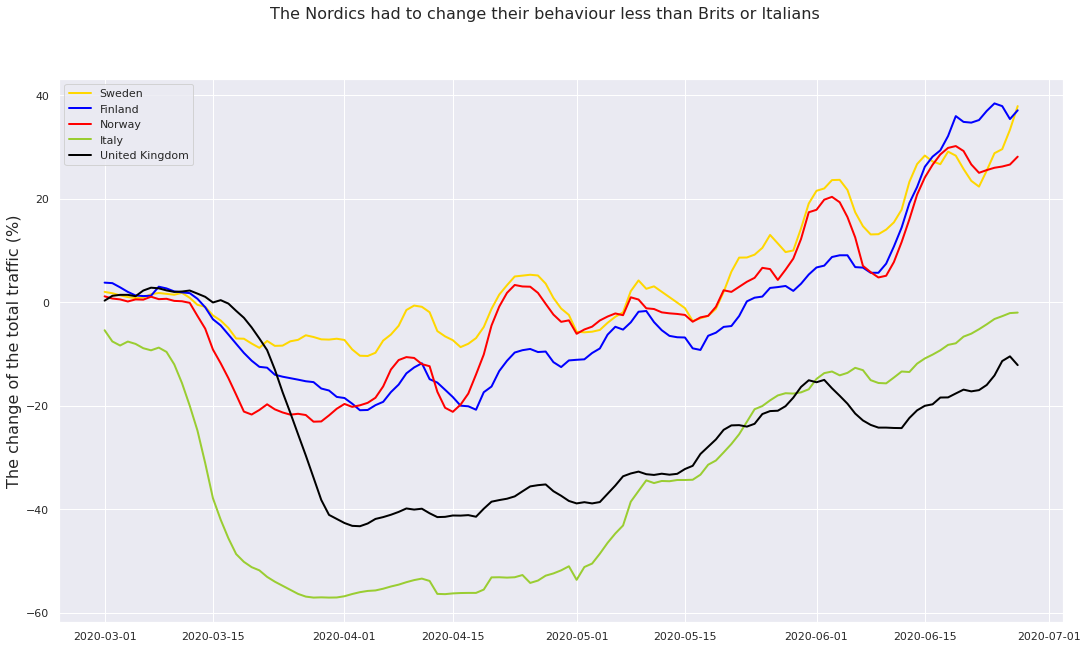

In [23]:
# REMARK: Smooth mobility is only used for this plot to make the graph clean

df1 = load_mobility_raw_onlynan()
plot_start_point = datetime.datetime.strptime('2020-03-01', '%Y-%m-%d')
df1 = df1[df1['date'] >= plot_start_point ]

fig = plt.figure(figsize=(18,10))

# Scandinavian countries
plt.plot( 'date', 'Smooth Mobility', data=df1.loc[(df1['country_region'] == 'Sweden')], 
        marker='', color='gold', linewidth=2, label="Sweden")
plt.plot( 'date', 'Smooth Mobility', data=df1.loc[(df1['country_region'] == 'Finland')],
         marker='', color='blue', linewidth=2, label="Finland")
plt.plot( 'date', 'Smooth Mobility', data=df1.loc[(df1['country_region'] == 'Norway')],
         marker='', color='red', linewidth=2, label="Norway")

# In comparision Austria, Italy
plt.plot( 'date', 'Smooth Mobility', data=df1.loc[(df1['country_region'] == 'Italy')],
         marker='', color='yellowgreen', linewidth=2, label="Italy")
plt.plot( 'date', 'Smooth Mobility', data=df1.loc[(df1['country_region'] == 'United Kingdom')],
         marker='', color='black', linewidth=2, label="United Kingdom")

plt.ylabel('The change of the total traffic (%)', fontsize=16)
fig.suptitle('The Nordics had to change their behaviour less than Brits or Italians', fontsize=16)
plt.legend(loc="upper left")

### The traffic was essential to get down in countries where COVID-19 escalated. However, there are countries who can deal with COVID-19 only getting the traffic down a little bit!

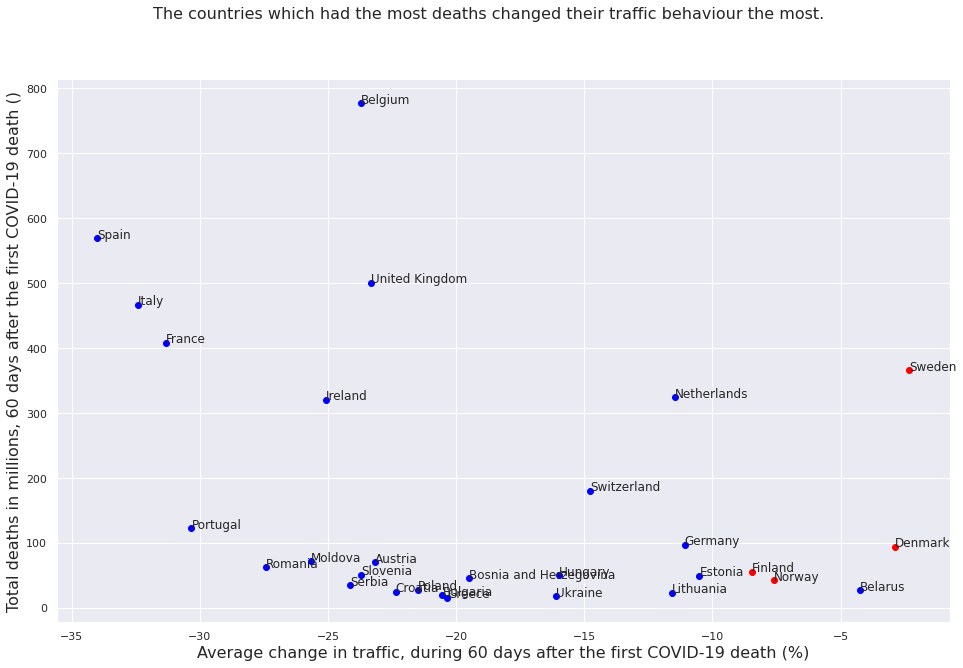

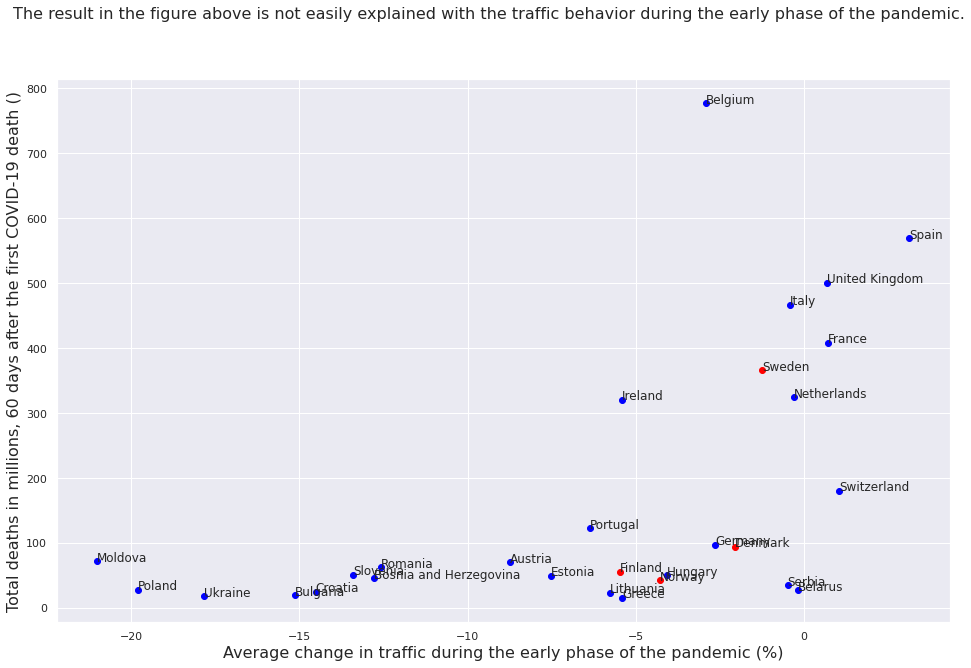

In [24]:
#####################################################################################

fig2, ax2 = plt.subplots(figsize=(16, 10))

ax2.scatter(df_countries['means_traffic_end'][0:num_nordic_countries], 
           df_countries['total_deaths_per_million_last'][0:num_nordic_countries], color='red')

ax2.scatter(df_countries['means_traffic_end'][num_nordic_countries:num_countries], 
           df_countries['total_deaths_per_million_last'][num_nordic_countries:num_countries], color='blue')

for i, txt in enumerate(european_countries):
    ax2.annotate(txt, (df_countries['means_traffic_end'][i],
                       df_countries['total_deaths_per_million_last'][i]))

plt.ylabel('Total deaths in millions, 60 days after the first COVID-19 death ()', fontsize=16)
# after 60 days at least 5 deaths is occured

plt.xlabel('Average change in traffic, during 60 days after the first COVID-19 death (%)', fontsize=16)
# Time interval starts 10 days before 5 deaths is occured and continues 60 days

fig2.suptitle('The countries which had the most deaths changed their traffic behaviour the most.', fontsize=16)
print()

#####################################################################################

fig1, ax1 = plt.subplots(figsize=(16, 10))

ax1.scatter(df_countries['means_traffic_beginning'][0:num_nordic_countries], 
           df_countries['total_deaths_per_million_last'][0:num_nordic_countries], color='red')

ax1.scatter(df_countries['means_traffic_beginning'][num_nordic_countries:num_countries], 
           df_countries['total_deaths_per_million_last'][num_nordic_countries:num_countries], color='blue')

for i, txt in enumerate(european_countries):
    ax1.annotate(txt, (df_countries['means_traffic_beginning'][i],
                       df_countries['total_deaths_per_million_last'][i]))

plt.ylabel('Total deaths in millions, 60 days after the first COVID-19 death ()', fontsize=16)
# after 60 days at least 5 deaths is occured

plt.xlabel('Average change in traffic during the early phase of the pandemic (%)', fontsize=16)
# Time interval starts 10 days before 5 deaths is occured and continues 20 days

fig1.suptitle('The result in the figure above is not easily explained with the traffic behavior during the early phase of the pandemic.', fontsize=16)

print()

### Let's make other plots where y-axis is 'Total deaths in millions, 60 days after the first COVID-19 death ()' to get understanding of the reasons behind high death rates

### Let's first plot those explanatory variables which give an intuitive result

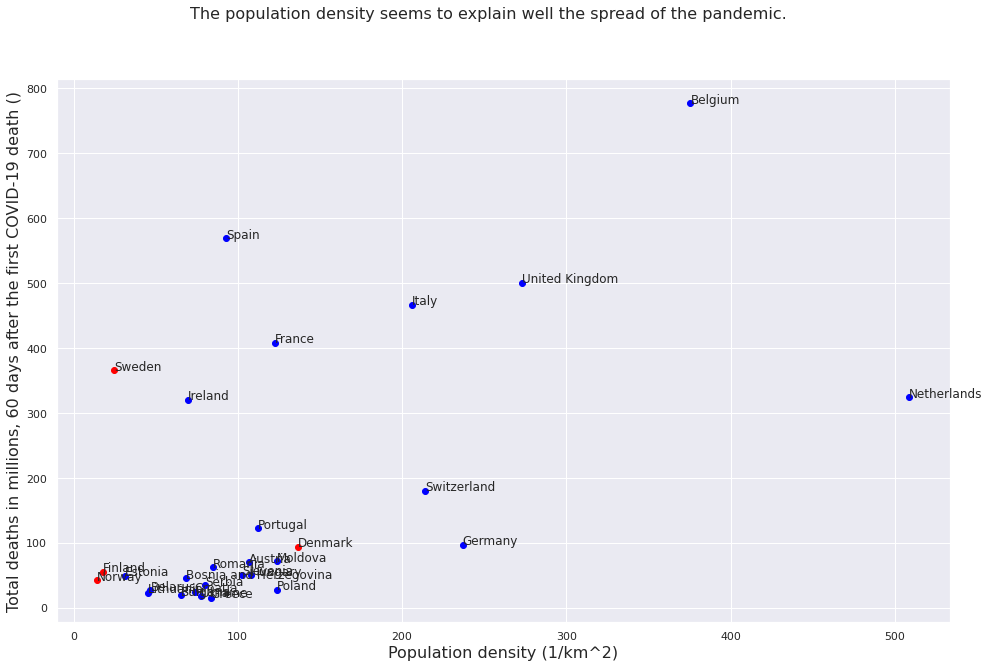

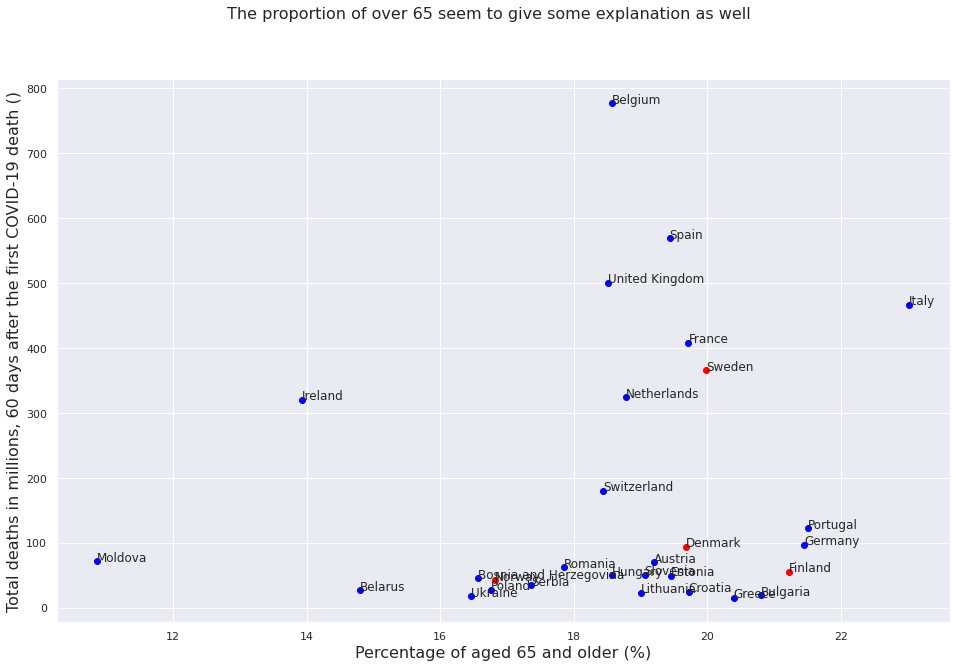

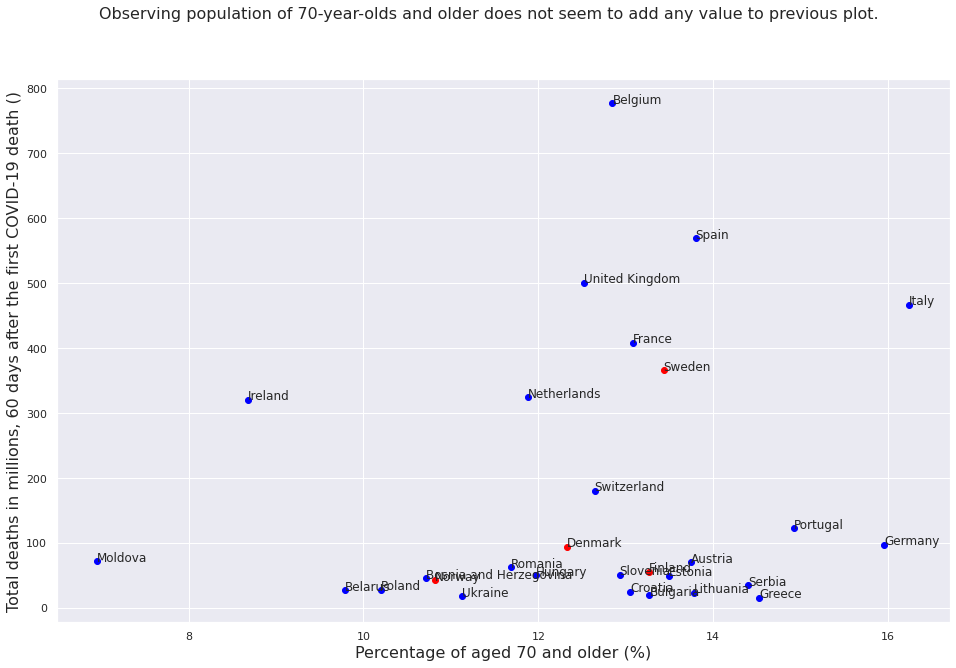

In [25]:
#####################################################################################
# Population density

fig, ax = plt.subplots(figsize=(16, 10))

ax.scatter(df_countries['population_density'][0:num_nordic_countries], 
           df_countries['total_deaths_per_million_last'][0:num_nordic_countries], color='red')

ax.scatter(df_countries['population_density'][num_nordic_countries:num_countries], 
           df_countries['total_deaths_per_million_last'][num_nordic_countries:num_countries], color='blue')

for i, txt in enumerate(european_countries):
    ax.annotate(txt, (df_countries['population_density'][i],
                       df_countries['total_deaths_per_million_last'][i]))

plt.ylabel('Total deaths in millions, 60 days after the first COVID-19 death ()', fontsize=16)
# after 60 days at least 5 deaths is occured

plt.xlabel('Population density (1/km^2)', fontsize=16)
# Time interval starts 10 days before 5 deaths is occured and continues 20 days

fig.suptitle('The population density seems to explain well the spread of the pandemic.',
             fontsize=16)


#####################################################################################
# The amount of over 65 year olds

fig, ax = plt.subplots(figsize=(16, 10))

ax.scatter(df_countries['aged_65_older'][0:num_nordic_countries], 
           df_countries['total_deaths_per_million_last'][0:num_nordic_countries], color='red')

ax.scatter(df_countries['aged_65_older'][num_nordic_countries:num_countries], 
           df_countries['total_deaths_per_million_last'][num_nordic_countries:num_countries], color='blue')

for i, txt in enumerate(european_countries):
    ax.annotate(txt, (df_countries['aged_65_older'][i],
                       df_countries['total_deaths_per_million_last'][i]))

plt.ylabel('Total deaths in millions, 60 days after the first COVID-19 death ()', fontsize=16)
# after 60 days at least 5 deaths is occured

plt.xlabel('Percentage of aged 65 and older (%)', fontsize=16)
# Time interval starts 10 days before 5 deaths is occured and continues 60 days

fig.suptitle('The proportion of over 65 seem to give some explanation as well',
             fontsize=16)


#####################################################################################
# The amount of over 70 year olds

fig, ax = plt.subplots(figsize=(16, 10))

ax.scatter(df_countries['aged_70_older'][0:num_nordic_countries], 
           df_countries['total_deaths_per_million_last'][0:num_nordic_countries], color='red')

ax.scatter(df_countries['aged_70_older'][num_nordic_countries:num_countries], 
           df_countries['total_deaths_per_million_last'][num_nordic_countries:num_countries], color='blue')

for i, txt in enumerate(european_countries):
    ax.annotate(txt, (df_countries['aged_70_older'][i],
                       df_countries['total_deaths_per_million_last'][i]))

plt.ylabel('Total deaths in millions, 60 days after the first COVID-19 death ()', fontsize=16)
# after 60 days at least 5 deaths is occured

plt.xlabel('Percentage of aged 70 and older (%)', fontsize=16)
# Time interval starts 10 days before 5 deaths is occured and continues 60 days
fig.suptitle('Observing population of 70-year-olds and older does not seem to add any value to previous plot.',
             fontsize=16)

print()

### Let's then plot those explanatory variables which give an surprising result

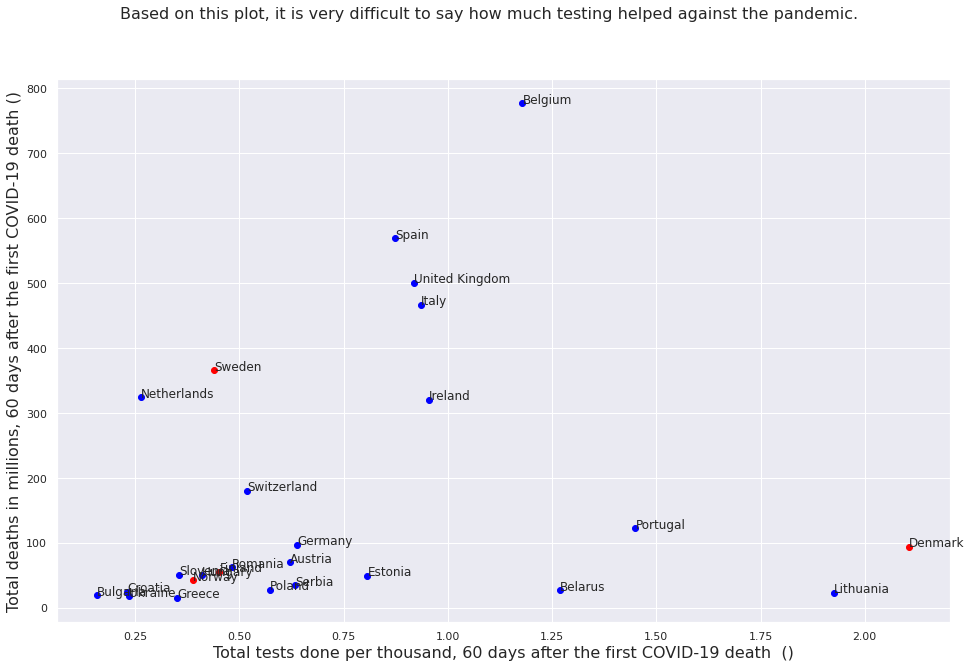

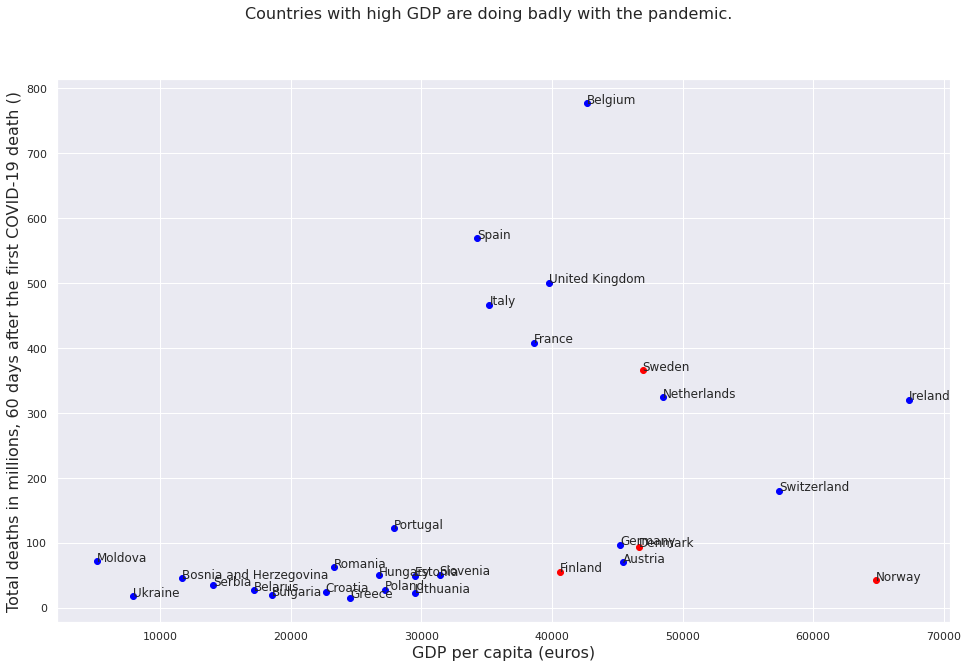

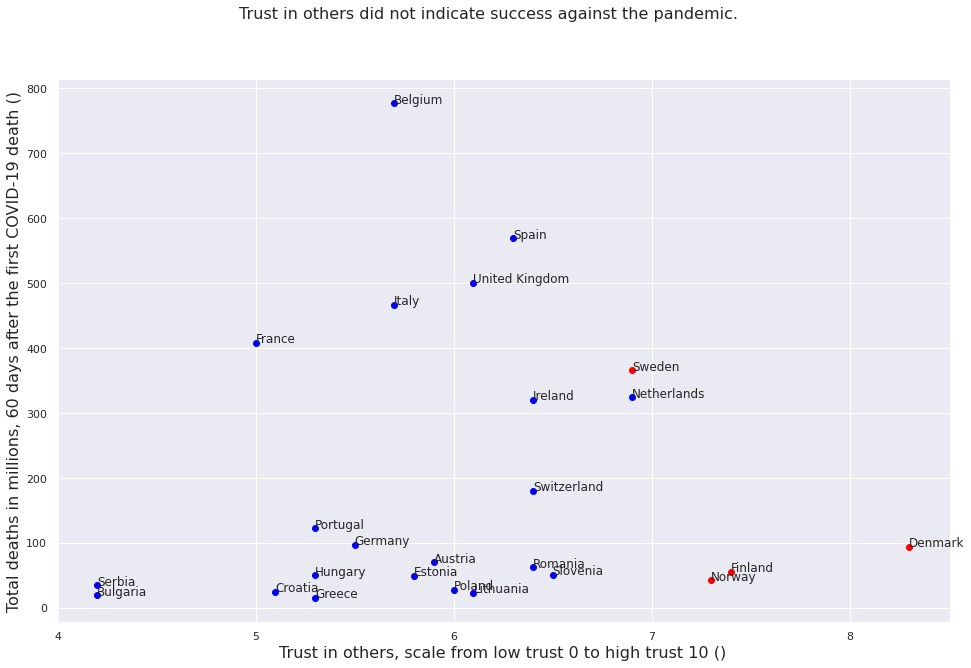

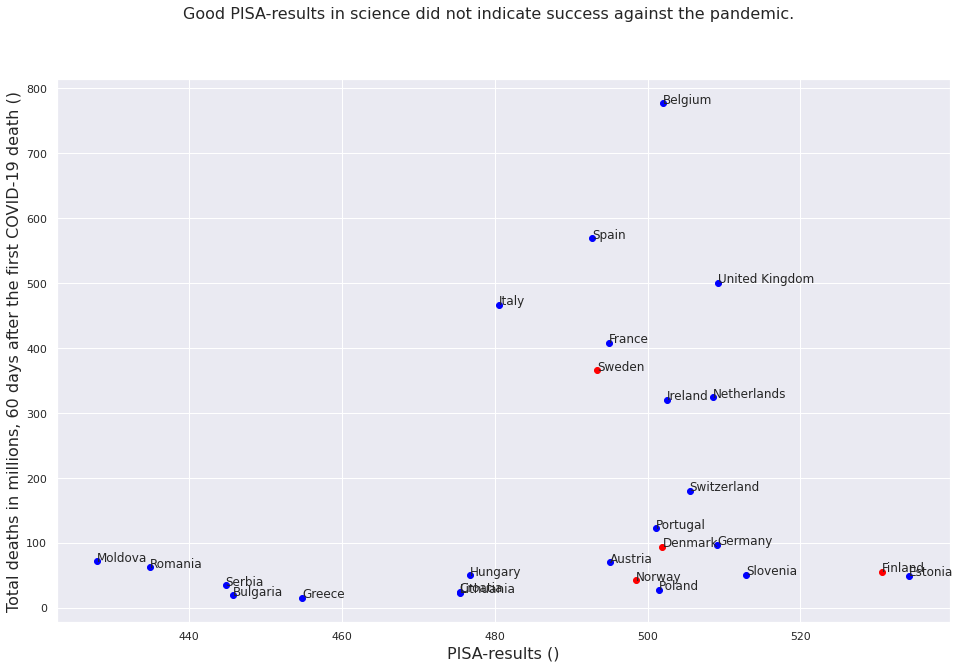

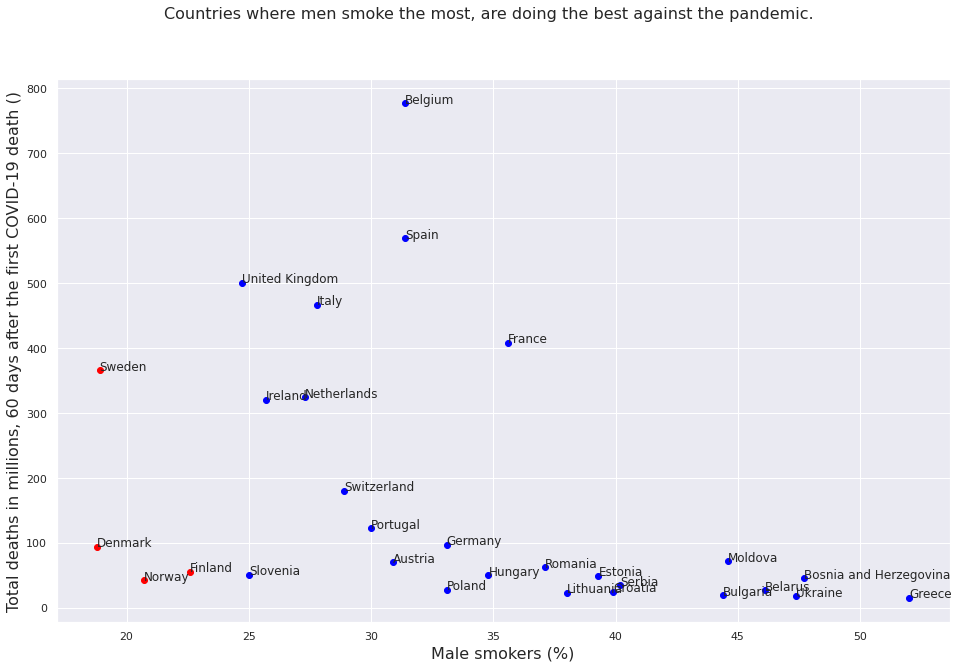

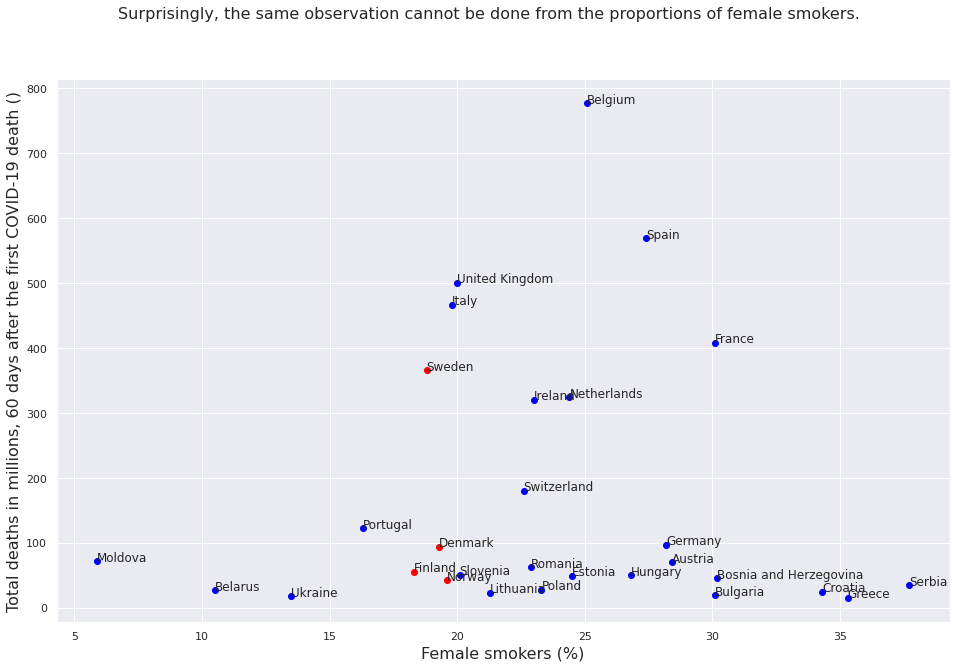

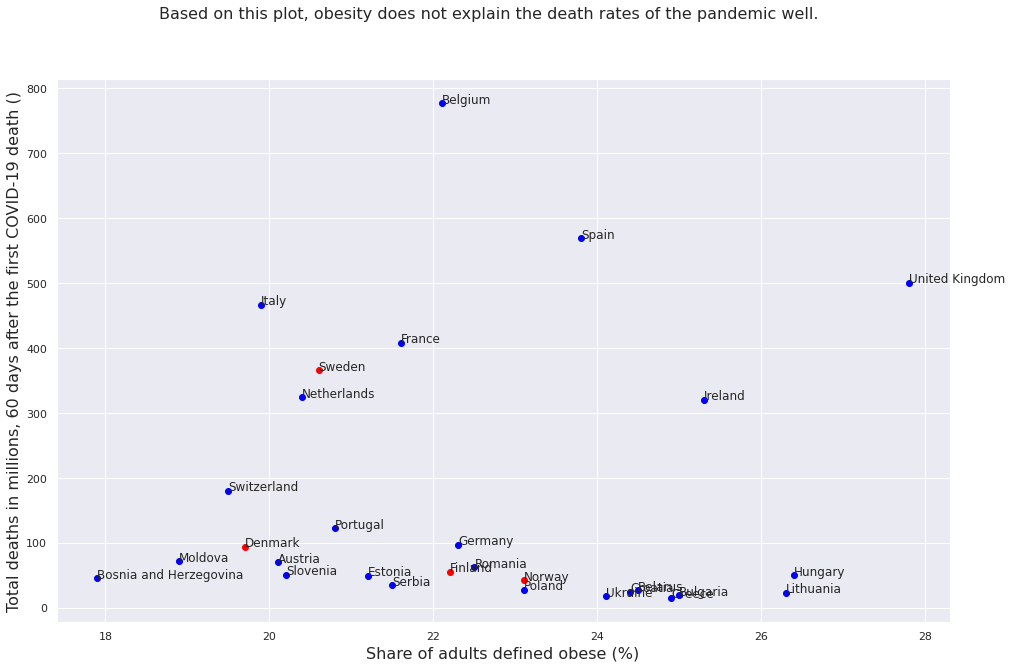

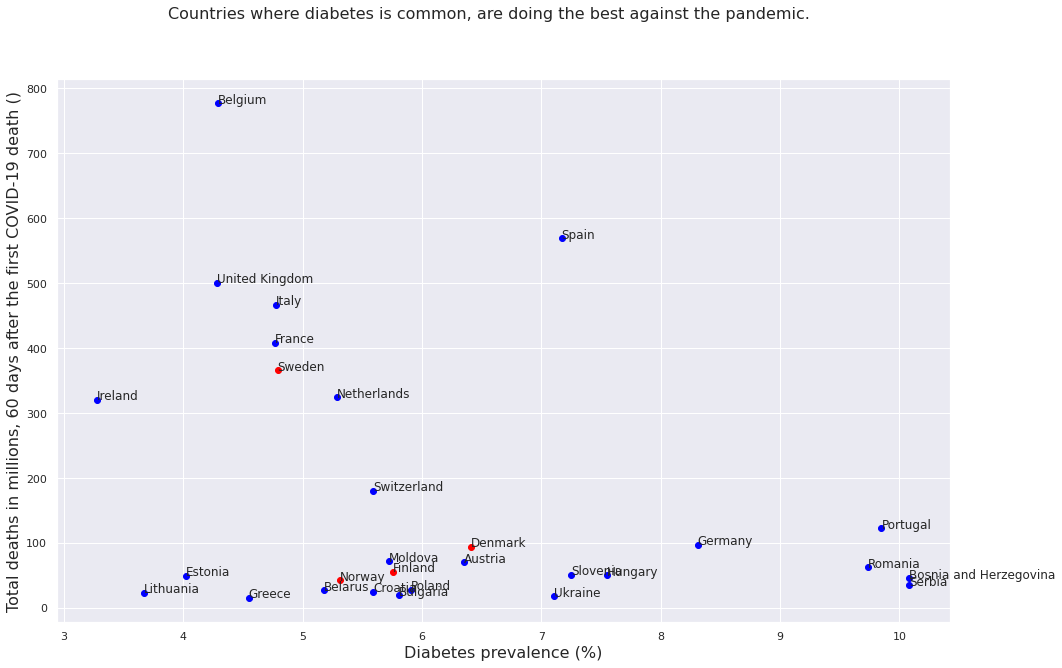

In [26]:
#####################################################################################
# Testing

fig, ax = plt.subplots(figsize=(16, 10))

ax.scatter(df_countries['total_tests_per_thousand_last'][0:num_nordic_countries], 
           df_countries['total_deaths_per_million_last'][0:num_nordic_countries], color='red')

ax.scatter(df_countries['total_tests_per_thousand_last'][num_nordic_countries:num_countries], 
           df_countries['total_deaths_per_million_last'][num_nordic_countries:num_countries], color='blue')

for i, txt in enumerate(european_countries):
    ax.annotate(txt, (df_countries['total_tests_per_thousand_last'][i],
                       df_countries['total_deaths_per_million_last'][i]))

plt.ylabel('Total deaths in millions, 60 days after the first COVID-19 death ()', fontsize=16)
# after 60 days at least 5 deaths is occured

plt.xlabel('Total tests done per thousand, 60 days after the first COVID-19 death  ()', fontsize=16)
# Time interval starts 10 days before 5 deaths is occured and continues 60 days
fig.suptitle('Based on this plot, it is very difficult to say how much testing helped against the pandemic.',
             fontsize=16)

#####################################################################################
# GDP per capita

fig, ax = plt.subplots(figsize=(16, 10))

ax.scatter(df_countries['gdp_per_capita'][0:num_nordic_countries], 
           df_countries['total_deaths_per_million_last'][0:num_nordic_countries], color='red')

ax.scatter(df_countries['gdp_per_capita'][num_nordic_countries:num_countries], 
           df_countries['total_deaths_per_million_last'][num_nordic_countries:num_countries], color='blue')

for i, txt in enumerate(european_countries):
    ax.annotate(txt, (df_countries['gdp_per_capita'][i],
                       df_countries['total_deaths_per_million_last'][i]))

plt.ylabel('Total deaths in millions, 60 days after the first COVID-19 death ()', fontsize=16)
# after 60 days at least 5 deaths is occured

plt.xlabel('GDP per capita (euros)', fontsize=16)
# Time interval starts 10 days before 5 deaths is occured and continues 60 days
fig.suptitle('Countries with high GDP are doing badly with the pandemic.',
             fontsize=16)


#####################################################################################
# Trust in others

fig, ax = plt.subplots(figsize=(16, 10))

ax.scatter(df_countries['trust_in_others'][0:num_nordic_countries], 
           df_countries['total_deaths_per_million_last'][0:num_nordic_countries], color='red')

ax.scatter(df_countries['trust_in_others'][num_nordic_countries:num_countries], 
           df_countries['total_deaths_per_million_last'][num_nordic_countries:num_countries], color='blue')

for i, txt in enumerate(european_countries):
    ax.annotate(txt, (df_countries['trust_in_others'][i],
                       df_countries['total_deaths_per_million_last'][i]))

plt.ylabel('Total deaths in millions, 60 days after the first COVID-19 death ()', fontsize=16)
# after 60 days at least 5 deaths is occured

plt.xlabel('Trust in others, scale from low trust 0 to high trust 10 ()', fontsize=16)
# Time interval starts 10 days before 5 deaths is occured and continues 60 days
fig.suptitle('Trust in others did not indicate success against the pandemic.',
             fontsize=16)


#####################################################################################
# PISA-results

fig, ax = plt.subplots(figsize=(16, 10))

ax.scatter(df_countries['pisa_results'][0:num_nordic_countries], 
           df_countries['total_deaths_per_million_last'][0:num_nordic_countries], color='red')

ax.scatter(df_countries['pisa_results'][num_nordic_countries:num_countries], 
           df_countries['total_deaths_per_million_last'][num_nordic_countries:num_countries], color='blue')

for i, txt in enumerate(european_countries):
    ax.annotate(txt, (df_countries['pisa_results'][i],
                       df_countries['total_deaths_per_million_last'][i]))

plt.ylabel('Total deaths in millions, 60 days after the first COVID-19 death ()', fontsize=16)
# after 60 days at least 5 deaths is occured

plt.xlabel('PISA-results ()', fontsize=16)
# Time interval starts 10 days before 5 deaths is occured and continues 60 days
fig.suptitle('Good PISA-results in science did not indicate success against the pandemic.',
             fontsize=16)



#####################################################################################
# Male smokers

fig, ax = plt.subplots(figsize=(16, 10))

ax.scatter(df_countries['male_smokers'][0:num_nordic_countries], 
           df_countries['total_deaths_per_million_last'][0:num_nordic_countries], color='red')

ax.scatter(df_countries['male_smokers'][num_nordic_countries:num_countries], 
           df_countries['total_deaths_per_million_last'][num_nordic_countries:num_countries], color='blue')

for i, txt in enumerate(european_countries):
    ax.annotate(txt, (df_countries['male_smokers'][i],
                       df_countries['total_deaths_per_million_last'][i]))

plt.ylabel('Total deaths in millions, 60 days after the first COVID-19 death ()', fontsize=16)
# after 60 days at least 5 deaths is occured

plt.xlabel('Male smokers (%)', fontsize=16)
# Time interval starts 10 days before 5 deaths is occured and continues 60 days

fig.suptitle('Countries where men smoke the most, are doing the best against the pandemic.',
             fontsize=16)


#####################################################################################
# Female smokers

fig, ax = plt.subplots(figsize=(16, 10))

ax.scatter(df_countries['female_smokers'][0:num_nordic_countries], 
           df_countries['total_deaths_per_million_last'][0:num_nordic_countries], color='red')

ax.scatter(df_countries['female_smokers'][num_nordic_countries:num_countries], 
           df_countries['total_deaths_per_million_last'][num_nordic_countries:num_countries], color='blue')

for i, txt in enumerate(european_countries):
    ax.annotate(txt, (df_countries['female_smokers'][i],
                       df_countries['total_deaths_per_million_last'][i]))

plt.ylabel('Total deaths in millions, 60 days after the first COVID-19 death ()', fontsize=16)
# after 60 days at least 5 deaths is occured

plt.xlabel('Female smokers (%)', fontsize=16)
# Time interval starts 10 days before 5 deaths is occured and continues 60 days

fig.suptitle('Surprisingly, the same observation cannot be done from the proportions of female smokers.',
             fontsize=16)

#####################################################################################
# Obesity

fig, ax = plt.subplots(figsize=(16, 10))

ax.scatter(df_countries['obesity'][0:num_nordic_countries], 
           df_countries['total_deaths_per_million_last'][0:num_nordic_countries], color='red')

ax.scatter(df_countries['obesity'][num_nordic_countries:num_countries], 
           df_countries['total_deaths_per_million_last'][num_nordic_countries:num_countries], color='blue')

for i, txt in enumerate(european_countries):
    ax.annotate(txt, (df_countries['obesity'][i],
                       df_countries['total_deaths_per_million_last'][i]))

plt.ylabel('Total deaths in millions, 60 days after the first COVID-19 death ()', fontsize=16)
# after 60 days at least 5 deaths is occured

plt.xlabel('Share of adults defined obese (%)', fontsize=16)
# Time interval starts 10 days before 5 deaths is occured and continues 60 days
fig.suptitle('Based on this plot, obesity does not explain the death rates of the pandemic well.',
             fontsize=16)


#####################################################################################
# The amount of diabetes prevalence

fig, ax = plt.subplots(figsize=(16, 10))

ax.scatter(df_countries['diabetes_prevalence'][0:num_nordic_countries], 
           df_countries['total_deaths_per_million_last'][0:num_nordic_countries], color='red')

ax.scatter(df_countries['diabetes_prevalence'][num_nordic_countries:num_countries], 
           df_countries['total_deaths_per_million_last'][num_nordic_countries:num_countries], color='blue')

for i, txt in enumerate(european_countries):
    ax.annotate(txt, (df_countries['diabetes_prevalence'][i],
                       df_countries['total_deaths_per_million_last'][i]))

plt.ylabel('Total deaths in millions, 60 days after the first COVID-19 death ()', fontsize=16)
# after 60 days at least 5 deaths is occured

plt.xlabel('Diabetes prevalence (%)', fontsize=16)
# Time interval starts 10 days before 5 deaths is occured and continues 60 days
fig.suptitle('Countries where diabetes is common, are doing the best against the pandemic.',
             fontsize=16)

print()

### The conclusion of the scatter plots:
1. We can divide Europe in Nordic countries, Eastern-Europe, South- and West-Europe and Middle-Europe based on the previous plots:
    - In general, Nordic-counties (f.e. Denmark, Finland, Norway) were not under a lot of pressure with the pandemic. They benefitted from their low population density and they had to change their traffic behavior only little. Their population is not particularly young or old in comparision to other European countries. 
    - Eastern-European countries (f.e. Belarus, Bulgaria, Greece) changed their traffic behavior strongly. They also benefitted from their low population density and young population. These three factors helped them to  keep the number of deaths low even if in these countries people smoke quite a lot.
    - South- and West-European countries (f.e. France, Spain, UK) had a lot of difficulties to deal with the pandemic even if they ended up changing their traffic behavior very much. They are countries with a high population density, and have a relatively old population. Also, obesity is quite common in these countries. These countries have a high GDP and people who have in many ways a healthy life style. However, these factors  seemed not to have a strong positive effect. 
    - Middle-European countries (f.e. Austria, Germany, Switzerland) got relatively average scores in each category measured above. Therefore the fact that the pandemic hit them but not very hard compared to other European countries, is logical.
    
2. In general, having a low population density and a young population were helpful to deal succesfully against the pandemic. Especially, the population density is important!
3. With these simple scatter plots, it is difficult to say anything about the effect of testing or obesity.
4. Counter-intuitively, countries with high GDP, PISA-scores, trust in other citizens and low proportion of smokers and people with diabetes, were doing worse than countries with lower scores in each categories.

### Is there a way to show that the population density is the most important factor to determine the negative harm? (And that age distribution and obesity would have some effect, GDP only little effect)

### A potential next step: Let's observe smaller regions in most succesful countries (Denmark, Belarus, Finland, Norway, Sweden) and so called unsuccesful countries (Italy, Belgium, UK, Spain) and simply scatter plot the these regions total_deaths_per_thousand and the population density. We should observe Nordic countries simply do not have the regions to spread the disease!

## Another central goal of this research: Understanding the nature how non-pharmaceutical interventions worked in Europe.

### Were the NPIs similar or different between countries in Europe?

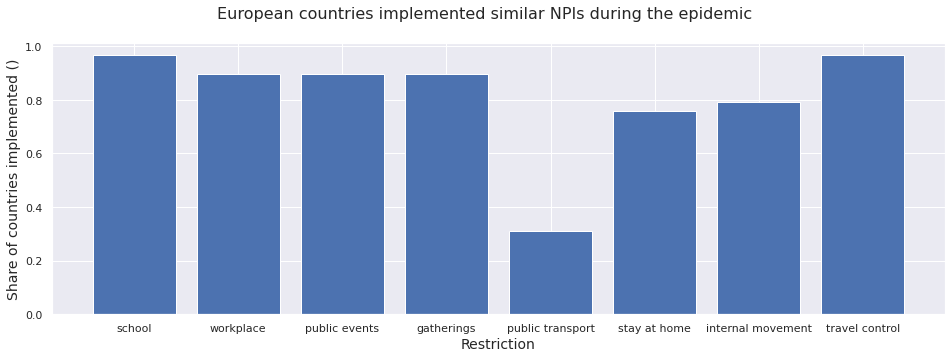

In [27]:
x = ['school', 'workplace', 'public events', 'gatherings', 'public transport',
     'stay at home', 'internal movement', 'travel control']
y = df_npis_on['implementation_percentage'].tolist() 

fig, ax= plt.subplots(figsize=(16, 5))

ax.bar(x,y)

plt.ylabel('Share of countries implemented ()', fontsize=14)
# after 60 days at least 5 deaths is occured

plt.xlabel('Restriction', fontsize=14)
# Time interval starts 10 days before 5 deaths is occured and continues 60 days

fig.suptitle('European countries implemented similar NPIs during the epidemic', fontsize=16)

print()

### Timing between NPI-implementations varied to some extend

In [28]:
pd.set_option('display.max_rows', None)
df_index

,school_closing_req_on,workplace_closing_req_on,cancel_public_events_req_on,restrictions_on_gatherings_req_on,close_public_transport_req_on,stay_at_home_req_on,restrictions_on_internal_movement_req_on,international_travel_controls_req_on,school_closing_req_off,workplace_closing_req_off,cancel_public_events_req_off,restrictions_on_gatherings_req_off,close_public_transport_req_off,stay_at_home_req_off,restrictions_on_internal_movement_req_off,international_travel_controls_req_off
0,[],[],[],[],[],[],[],"[Finland, France, Italy, Romania]",[],[],[],[],[],[],[],[]
1,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
2,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
3,[Ukraine],[],[Ukraine],[],[],[],[Ukraine],[],[],[],[],[],[],[],[],[]
4,[Germany],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
5,[],[],[],[],[],[],[],[Moldova],[],[],[],[],[],[],[],[]
6,[Bulgaria],[],[],[],[],[],[],[Belarus],[],[],[],[],[],[],[],[]
7,[],[],"[Poland, Moldova]",[Moldova],[],[],[],[Ukraine],[],[],[],[],[],[],[],[]
8,[Moldova],"[Ukraine, Moldova]",[Greece],[Ukraine],[],[],[],[],[],[],[],[],[],[],[],[]
9,[Poland],[],[],[],[Ukraine],[],[],[],[],[],[],[],[],[],[],[]


### What do traffic and infected coefficients practically mean?

Example: Sweden

Sweden has 9 NPI-intervals. Each interval starts with a green line. Using linear regression,
for each interval there has been fitted a line.

NPI-interval number 1 has infected coefficient: 2.17 and traffic coefficient: 0.07
NPI-interval number 2 has infected coefficient: 18.00 and traffic coefficient: 0.17
NPI-interval number 3 has infected coefficient: -11.17 and traffic coefficient: -1.40
NPI-interval number 4 has only one point -> can't fit a line!
NPI-interval number 5 has infected coefficient: -2.37 and traffic coefficient: -0.88
NPI-interval number 6 has infected coefficient: 12.54 and traffic coefficient: -0.91
NPI-interval number 7 has infected coefficient: 56.00 and traffic coefficient: -2.42
NPI-interval number 8 has infected coefficient: 5.19 and traffic coefficient: 0.48
NPI-interval number 9 has infected coefficient: -5.94 and traffic coefficient: 0.12


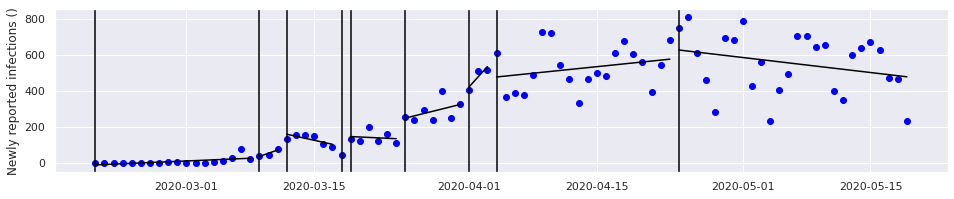

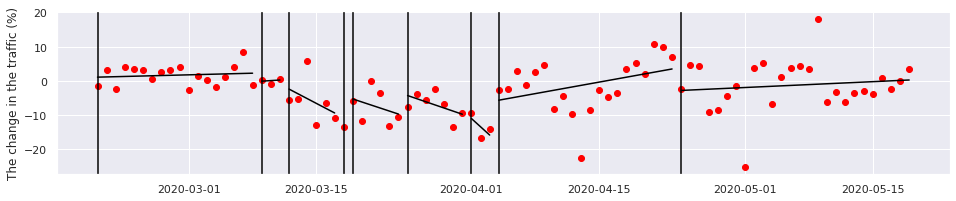

In [29]:
# Example Sweden

df_days_sweden = df_days[(df_days['country'] == 'Sweden')]
df_npi_interval_sweden = df_npi_interval[(df_npi_interval['country'] == 'Sweden')]


fig, ax = plt.subplots(figsize=(16, 3))
ax.scatter(df_days_sweden['date'], df_days_sweden['new_infections'], color='blue')

for i in range(len(df_npi_interval_sweden['interval_start_date'])):
    infected_coefficient = df_npi_interval_sweden['infected_coefficients'][i]
    infected_intercept = df_npi_interval_sweden['infected_intercepts'][i]
    
    interval_len = df_npi_interval_sweden['npi_interval_len'][i]
    t = range(interval_len)
    infected_fitted = np.multiply([infected_coefficient] * len(t), t) + np.array([infected_intercept] * len(t))

    date_interval = [df_npi_interval_sweden['interval_start_date'][i] + datetime.timedelta(days=x) for x in range(interval_len)]
    
    if interval_len >= 2:
        ax.plot(date_interval, infected_fitted, color='black')

plt.ylabel('Newly reported infections ()', fontsize=12)

for i in range(len(df_npi_interval_sweden['interval_start_date'])):
    plt.axvline(df_npi_interval_sweden['interval_start_date'][i], color='black')

####################################################################################

fig2, ax2 = plt.subplots(figsize=(16, 3))
ax2.scatter(df_days_sweden['date'], df_days_sweden['total_traffic'], color='red')

for i in range(len(df_npi_interval_sweden['interval_start_date'])):
    traffic_coefficient = df_npi_interval_sweden['traffic_coefficients'][i]
    traffic_intercept = df_npi_interval_sweden['traffic_intercepts'][i]
    
    interval_len = df_npi_interval_sweden['npi_interval_len'][i]
    t = range(interval_len)
    traffic_fitted = np.multiply([traffic_coefficient] * len(t), t) + np.array([traffic_intercept] * len(t))

    date_interval = [df_npi_interval_sweden['interval_start_date'][i] + datetime.timedelta(days=x) for x in range(interval_len)]
    if interval_len >= 2:
        ax2.plot(date_interval, traffic_fitted, color='black')

plt.ylabel('The change in the traffic (%)', fontsize=12)

for i in range(len(df_npi_interval_sweden['interval_start_date'])):
    plt.axvline(df_npi_interval_sweden['interval_start_date'][i], color='black')

print("Example: Sweden")
print()
print("Sweden has 9 NPI-intervals. Each interval starts with a green line. Using linear regression,")
print("for each interval there has been fitted a line.")
print()

for i in range(len(df_npi_interval_sweden['interval_start_date'])):
    interval_num = i + 1
    infected_coefficient = df_npi_interval_sweden['infected_coefficients'][i]
    traffic_coefficient = df_npi_interval_sweden['traffic_coefficients'][i]
    
    if infected_coefficient != -1000:
        print("NPI-interval number %d has infected coefficient: %.2f and traffic coefficient: %.2f" % (interval_num, infected_coefficient, traffic_coefficient))
    else:
        print("NPI-interval number %d has only one point -> can't fit a line!" %interval_num)

### Let's find correlations between the traffic and the infected coefficients

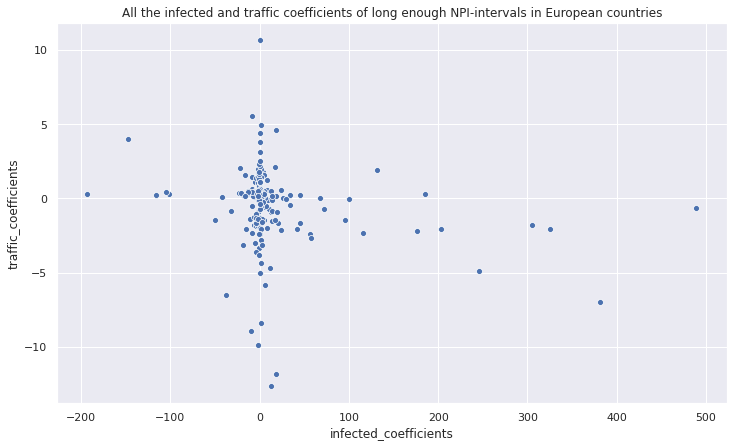

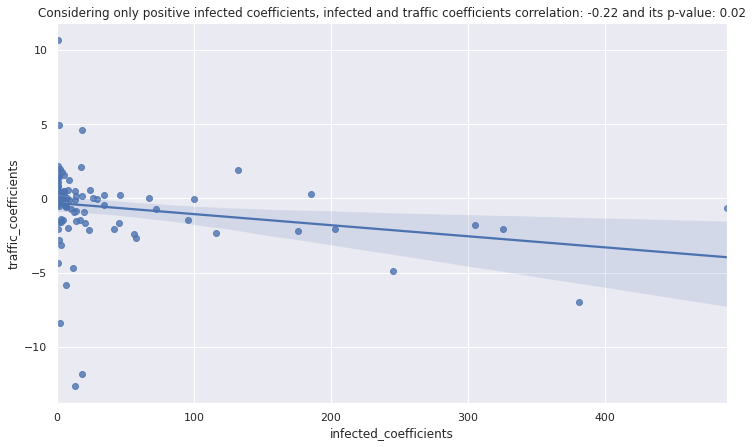

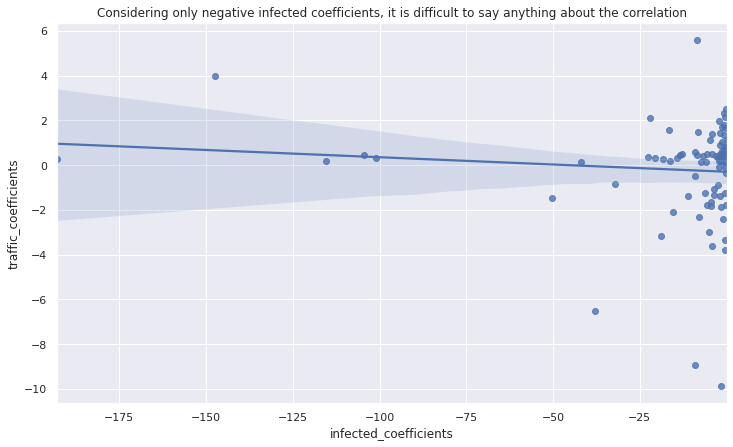

In [30]:
df_npi_interval_mod0 = df_npi_interval[(df_npi_interval['npi_interval_len'] >= 3)]

fig3, ax3 = plt.subplots(figsize=(12, 7))

ax3.set_title('All the infected and traffic coefficients of long enough NPI-intervals in European countries')

ax3 = sns.scatterplot(x="infected_coefficients", y="traffic_coefficients", #hue="npi_interval_len",
        data=df_npi_interval_mod0)
# potential hues and sizes: npi_increment, npi_interval_len

##################################################################################

df_npi_interval_mod1 = df_npi_interval[(df_npi_interval['npi_interval_len'] >= 3) &
                  (df_npi_interval['infected_coefficients'] > 0)]

fig4, ax4 = plt.subplots(figsize=(12, 7))

x = df_npi_interval_mod1['infected_coefficients']
y = df_npi_interval_mod1['traffic_coefficients']

slope, intercept, r, p, stderr = stats.linregress(x, y)  # r is pearson correlation
#print(stats.linregress(x, y))

ax4.set_title('Considering only positive infected coefficients, infected and traffic coefficients correlation: %.2f and its p-value: %.2f' % (r, p))

ax4 = sns.regplot(x="infected_coefficients", y="traffic_coefficients",
                     data=df_npi_interval_mod1)

##################################################################################

df_npi_interval_mod2 = df_npi_interval[(df_npi_interval['npi_interval_len'] >= 3) &
                  (df_npi_interval['infected_coefficients'] < 0)]

fig5, ax5 = plt.subplots(figsize=(12, 7))

x = df_npi_interval_mod2['infected_coefficients']
y = df_npi_interval_mod2['traffic_coefficients']

# slope, intercept, r, p, stderr = stats.linregress(x, y)  # r is pearson correlation
#print(stats.linregress(x, y))

ax5.set_title('Considering only negative infected coefficients, it is difficult to say anything about the correlation')


ax5 = sns.regplot(x="infected_coefficients", y="traffic_coefficients", 
                     data=df_npi_interval_mod2)